In [1]:
using PyPlot, Random, LinearAlgebra, Statistics, StatsBase

In [2]:
include("../simulations/lozi-map.jl")
function mapslices_ith(f,A::Array{Ivl{T}}) where T
    fA = Array{T}(undef,2,size(A)...)
    for i in eachindex(A)
        fA[:,i...] = f(A[i]())
    end
    fA
end

mapslices_ith (generic function with 1 method)

In [3]:
setprecision(BigFloat,2precision(Float64))
const T = BigFloat
const p = T.((180//100,35//100))
const prec = 1e-8

1.0e-8

In [36]:
N = 10^5; Nedg = 10000; 
Nsubs = 10; persubs = div(N,Nsubs); 
totalN = N + 2Nedg
carerange = Nedg .+(1:N)

10001:110000

In [37]:
It = Ivl((0.5rand(T),0.5rand(T)),(0.5rand(T),0.5rand(T)),rand(T))::Ivl{T}
u = rand(T,2)
for n = 1:Nedg
    u = Jmap(It,p)*u; u /= norm(u)
    It = smap(It,p)
end
Ith = Array{Ivl{T}}(undef,totalN)
uh = Array{T}(undef,2,totalN)
lyh = Array{T}(undef,totalN)
sgh = BitArray(undef,totalN)
for n = 1:totalN
    u = Jmap(It,p)*u; ly = norm(u); u /= ly
    It = smap(It,p)
    Ith[n] = It; uh[:,n] = u; lyh[n] = ly
    sgh[n] = iscrossing(It)
end

sh = Array{T}(undef,2,N+2Nedg)
s = T.([0,1])
for n in totalN:-1:1
    s = Jmap(Ith[n],p)'*s; s /= dot(s,uh[:,n])
    sh[:,n] = s
end

# xh = xh[:,carerange]; uh = uh[:,carerange]; sh = sh[:,carerange]

In [38]:
lyapunov_exponents = [0,log(p[2])] + mean(log.(lyh))*[1,-1]
K = min(90,round(Int,-log(eps(T))/lyapunov_exponents[1])) 
    # after the second part we don't trust the pushforward of the singular measure
    # and I don't think we'll get much meaningful after 80

90

In [39]:
Xh = mapslices_ith(X,Ith)
Xh_uproj = [dot(sh[:,i],Xh[:,i]) for i = 1:totalN];

In [53]:
# What if we just did it by calculating it like with the stable part
LRTu_naive = zeros(Nsubs,K)
for n in carerange
    nss = div(n-1-Nedg,persubs)+1
    Xsp = Xuh[:,n]
    for k = 1:K
        ind = n+k-1
        LRTu_naive[nss,k] += dot(gradAh[:,ind],Xsp)
        Xsp = Jmap(Ith[ind],p)*Xsp
    end
end
LRTu_naive /= persubs;
mLRT_naive = mean(LRT,dims=1); sLRT_naive = mapslices(sem,LRT,dims=1);

In [41]:
LRTs = zeros(Nsubs,K)
gradAh = mapslices_ith(gradA,Ith)
Xuh = uh .* Xh_uproj'
Xsh = Xh - Xuh
for n in carerange
    nss = div(n-1-Nedg,persubs)+1
    Xsp = Xsh[:,n]
    for k = 1:K
        ind = n+k-1
        LRTs[nss,k] += dot(gradAh[:,ind],Xsp)
        Xsp = Jmap(Ith[ind],p)*Xsp
    end
end
LRTs /= persubs;
LRTs[:,findlast(vec(std(LRTs,dims=1)).<prec/K)+1:end] .= 0;

In [42]:
# kappa^X
u_dX_mean = zeros(T,Nsubs)
LRTu_dX = zeros(T,Nsubs,K)
Ah = A.(call.(Ith))
for n in carerange
    nss = div(n-1-Nedg,persubs)+1
    divXup = dot(sh[:,n],JX(Ith[n]()) * uh[:,n]) 
    u_dX_mean[nss] += divXup
    for k = 1:K
        ind = n+k-1
        LRTu_dX[nss,k] += Ah[ind]*divXup
    end
end
LRTu_dX /= -persubs;
u_dX_mean /= -persubs;

In [43]:
const covector_prop = round(Int,-log(prec)/sum(abs.(lyapunov_exponents)))
        # how far forward to propagate interval endpoints to get unstable covector
function get_covector(x,p)
    symv = BitArray(undef,covector_prop);
    for m = 1:covector_prop
        symv[m] = (x[1] > 0);
        x = smap(x,p);
    end
    s_p = T.([0,1]); 
#     Jplus = Jmap(true,p)'; Jminus = Jmap(false,p)'
    for m = covector_prop:-1:1
#         s_p = (symv[m] ? Jplus : Jminus)*s_p;
        Jmap_conj!(s_p,symv[m],p)
    end
    s_p
end
get_covector(x,p,u) = begin s = get_covector(x,p); s / dot(s,u); end

get_covector (generic function with 2 methods)

In [44]:
# kappa^rho
u_dr_mean = zeros(T,Nsubs)
LRTu_dr = zeros(T,Nsubs,K)

for n in carerange
    nss = div(n-1-Nedg,persubs)+1
    u = view(uh,:,n); 
    p_dt = dt(Ith[n])
    wt = 1/norm(p_dt) # because we're sampling over points not intervals

    for (endpt, sgn) = ((Ith[n].p,-1),(Ith[n].q,1))
        s_p = get_covector(endpt,p,u)
        p_f = endpt;

        u_points = sgn * sign.(dot(-u,p_dt))
        X_p = u_points * dot(s_p,X(p_f)) * wt;
        u_dr_mean[nss] += X_p
        for k = 1:K
            LRTu_dr[nss,k] += X_p*A(p_f)
            p_f = smap(p_f,p)
        end
    end
end
LRTu_dr /= -persubs
u_dr_mean /= -persubs;

In [45]:
# kappa^l

# function compute_u_dl()
    u_dl_mean = zeros(T,Nsubs)
    LRTu_dl = zeros(T,Nsubs,K); fwd_prop = covector_prop
    for n in carerange
        sgh[n] || continue
        nss = div(n-1-Nedg,persubs)+1
        zt = getsingulart(Ith[n])
        z = smap(Ith[n](zt),p)
        s_z = get_covector(z,p)
        sminus = Jmap(false,p)'*s_z; splus = Jmap(true,p)'*s_z
        u = uh[:,n]
        ds = (splus/dot(u,splus) - sminus/dot(u,sminus))
        ds *= sign(u[1]) # so our coords for the jump are in the direction of u

        # propagate singularity backwards - should go in lozi-map.jl
        sing_orbit = Array{Tuple{T,T}}(undef,fwd_prop+K-1)
        sing_orbit[fwd_prop] = Ith[n](zt)
        for m = 1:fwd_prop-1
            if iscrossing(Ith[n-m]) 
                t_sg = getsingulart(Ith[n-m])
                if Ith[n-m].t <= t_sg
                    zt = t_sg*zt
                else
                    zt = t_sg + (1-t_sg)*zt
                end
            end
            sing_orbit[fwd_prop-m] = Ith[n-m](zt)
        end
        # propagate singularity forwards
        for m = fwd_prop.+(1:K-1)
            sing_orbit[m] = smap(sing_orbit[m-1],p)
        end
        A_sing_orbit = A.(sing_orbit)

        wt = norm(dt(Ith[n]))
        X_sing_orbit = X.(sing_orbit)
        for m = fwd_prop:-1:1
            ts_index = n - fwd_prop + m
            Xp = dot(ds,X_sing_orbit[m]) / wt
            u_dl_mean[nss] += Xp
            for k = 1:K
                LRTu_dl[nss,k] += Xp * A_sing_orbit[m+k-1]
            end
            Jmap_conj!(ds,Ith[ts_index-1](),p) #/ lyh[ts_index] # Δl gets shrunk by lyh but then we have to correct for sampling ???
        end
    end
    LRTu_dl /= -persubs # or sum(sgh[carerange])???
    u_dl_mean /= -persubs;
#     LRTu_dl, u_dl_mean
# end

In [20]:
using JLD
# save("../data/Susceptibility.jld","LRTs",LRTs,"LRTu_dX",LRTu_dX,"LRTu_dr",LRTu_dr,"LRTu_dl",LRTu_dl,"LRTu_naive",LRTu_naive,"p",p,"N",N,"K",K)

┌ Warning: JLD incorrectly extends FileIO functions (see FileIO documentation)
└ @ FileIO /home/cwormell/.julia/packages/FileIO/FUXWu/src/loadsave.jl:217


In [8]:
# using JLD
# @load "../simulations/Susceptibility.jld"

8-element Vector{Symbol}:
 :K
 :LRTs
 :LRTu_dX
 :LRTu_dl
 :LRTu_dr
 :LRTu_naive
 :N
 :p

In [54]:
LRT_naive = zeros(Nsubs,K)
gradAh = mapslices_ith(gradA,Ith)
for n in carerange
    nss = div(n-1-Nedg,persubs)+1
    Xsp = Xh[:,n]
    for k = 1:K
        ind = n+k-1
        LRT_naive[nss,k] += dot(gradAh[:,ind],Xsp)
        Xsp = Jmap(Ith[ind],p)*Xsp
    end
end
LRT_naive /= persubs;
mLRT_naive = mean(LRT_naive,dims=1); sLRT_naive = mapslices(sem,LRT_naive,dims=1);

In [55]:
LRT = LRTs + LRTu_dX + LRTu_dr + LRTu_dl;
# LRT_naive = LRTu_naive + LRTs
mLRT = mean(LRT,dims=1); sLRT = mapslices(sem,LRT,dims=1);

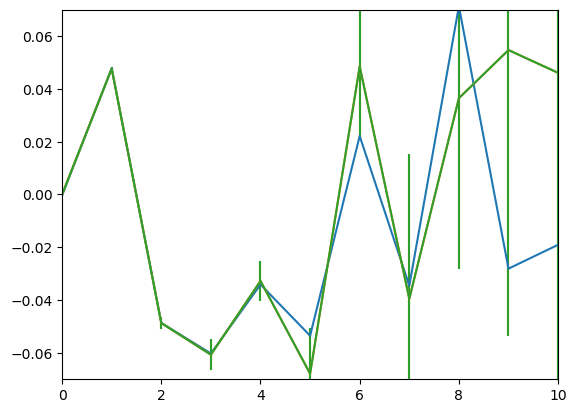

(0, 10)

In [60]:
for LRTv = (LRT,LRT_naive,LRTu_naive + LRTs)
    errorbar(0:K-1,Float64.(vec(mean(LRTv,dims=1))),2Float64.(vec(mapslices(sem,LRTv,dims=1))))
end
ylim(-0.07,0.07)
xlim(0,10)

In [18]:
println("$(mean(u_dX_mean + u_dr_mean + u_dl_mean)) ± $(2sem(u_dX_mean + u_dr_mean + u_dl_mean))"); 
## should be zero

0.000529893970569878265606807938100936 ± 0.00138838489629858220583879837679546


In [22]:
sum(mLRT[1:30]),hypot(sLRT[1:30]...)

(-0.174504466212322238577573904253718, 0.0044405083836778996232423955553215)

In [11]:
# plot(LRTs + LRTu_pts + LRTu_edges + LRTu_fwd)
figure(figsize=(5,4))
for (leg,LRTv,c) = (("\$\\kappa^s_n\$: stable direction",LRTs,"C0"),
                    ("\$\\kappa^X_n\$: \$X\$ derivative",LRTu_dX,"C1"),
                    ("\$\\kappa^\\rho_n\$: \$\\rho\$ derivative",LRTu_dr,"C2"),
                    ("\$\\kappa^l_n\$: \$l\$ derivative",LRTu_dl,"C3"),
                    ("\$\\kappa_n\$: total",LRT,"k")#,LRT_naive
    )
    errorbar(0:K-1,Float64.(vec(mean(LRTv,dims=1))),2Float64.(vec(mapslices(sem,LRTv,dims=1))),label=leg,c=c)
end
legend()
xlabel("n");ylabel("Contribution to \$\\kappa_n\$")
# plot(resp_file[1:K],"kx-")
plot(-1:K,zeros(K+2),"--",c="gray")
xlim(-0.5,K-3/2)
# ylim(-0.04,0.04)
tight_layout()
savefig("../figures/Susceptibility.pdf")


In [50]:
using PyCall
ag1 = pyimport("mpl_toolkits.axes_grid1.inset_locator")
littleaxes = ag1.inset_locator.inset_axes(gca(), width="30%", height="40%", loc=3)

PyObject <module 'mpl_toolkits.axes_grid1.inset_locator' from '/usr/lib/python3/dist-packages/mpl_toolkits/axes_grid1/inset_locator.py'>

In [13]:
# println("Stable (LY) dimension = $(Float64(round(-lyapunov_exponents[1]/diff(lyapunov_exponents)[1],digits=4)))")
LRTcutoff = findlast(vec(abs.(mLRT) .> 3sLRT))
println("LRT cutoff = $LRTcutoff")
# mean(LRT,dims=1)
totalLRT = sum(LRT[:,1:LRTcutoff],dims=2)
mtotalLRT, stotalLRT = mean(totalLRT), sem(totalLRT)

LRT cutoff = 64


(-0.174869674841840573116631463453989, 0.000724044540620202379147998511211329)

In [77]:
mean(LRTu_dl,dims=1)

1×90 Array{BigFloat,2}:
 0.0048618  0.0444215  -0.0675705  …  0.00164589  0.00158796  0.0016403

In [24]:
[vec(mLRT) 2vec(sLRT)]

60×2 Array{Float64,2}:
  0.000188537  0.000265665
  0.0479501    0.000308815
 -0.0486924    0.000273413
 -0.0608654    0.000246432
 -0.0340201    0.000270845
 -0.0534726    0.000349324
  0.0217337    0.000327124
 -0.0341069    0.00035182
  0.0710841    0.00025845
 -0.027166     0.00044776
 -0.0191183    0.000348171
 -0.0228759    0.00034676
 -0.00833073   0.000323263
  ⋮            
 -0.00090579   0.000365309
  0.00019665   0.000422137
  0.000257638  0.000425114
  0.00136733   0.000439745
 -0.000541618  0.000362945
  0.000548519  0.000356395
 -0.000167678  0.000389493
  0.000233031  0.000375843
 -0.000372601  0.00036128
  0.000650929  0.000389616
  0.000997914  0.000368202
 -0.000593631  0.000361936